In [1]:
library(tidyverse)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
projects <- c("CESC", "UCS", "UCEC")

In [3]:
text_size <- 11
guide_size <- 1
family <- "arial"
dpi <- 320
ht <- 4
wd <- 5

In [4]:
pval_thresh <- 0.05
qval_thresh <- 0.15

In [5]:
univ_dfs <- list()
l1_cph_dfs <- list()
for (dset_idx in 1:3) {
    univ_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/survival/", unified_dsets[dset_idx], "_univ_survival_results.tsv")) %>%
        filter(km_pval < 0.05 | cph_pval < 0.05) %>%
        filter(km_qval < 0.15 | cph_qval < 0.15)
    l1_cph_dfs[[projects[dset_idx]]] <- read_tsv(paste0(dirs$analysis_dir, "/survival/", unified_dsets[dset_idx], "_l1_cph_results.tsv"))
}


-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  km_pval = col_double(),
  km_qval = col_double(),
  cph_pval = col_double(),
  cph_qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  km_pval = col_double(),
  km_qval = col_double(),
  cph_pval = col_double(),
  cph_qval = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character()
)



-- Column specification -------------------------------

In [18]:
surv_df <- tibble(geneID = union(purrr::map(univ_dfs, "geneID") %>% unlist(), purrr::map(l1_cph_dfs, "geneID") %>% unlist()))
for (dset_idx in 1:3) {
    univ_col <- paste0(projects[dset_idx], "_univ")
    l1_col <- paste0(projects[dset_idx], "_l1")
    surv_df <- surv_df %>%
        mutate(
            !!as.name(univ_col) := geneID %in% univ_dfs[[projects[dset_idx]]]$geneID,
            !!as.name(l1_col) := geneID %in% l1_cph_dfs[[projects[dset_idx]]]$geneID
        )
}

surv_df <- surv_df %>%
    mutate(checks = rowSums(.[-1])) %>%
    select(geneID, checks, CESC_l1, CESC_univ, UCEC_l1, UCEC_univ, UCS_l1, UCS_univ) %>%
    mutate(last_true = max.col(.[,-c(1:2)], "last")) %>%
    arrange(checks, desc(last_true), desc(geneID)) %>%
    mutate(geneID_f = factor(geneID, levels = geneID)) %>%
    select(geneID_f, last_true, everything())

In [19]:
hm_surv_df <- surv_df %>%
    pivot_longer(cols = colnames(.[-c(1:4)]), names_to = "sig_list") %>%
    mutate(value = ifelse(value == TRUE, "yes", "no"), value = factor(value, levels = c("yes", "no")))
# head(hm_surv_df)

In [20]:
unique_sig_list <- unique(hm_surv_df$sig_list)
analysis_labs <- gsub("univ", "Univariate", gsub("l1", "Cox Lasso", gsub("_", " ", unique_sig_list)))
names(analysis_labs) <- unique_sig_list

Saving 5 x 6.67 in image



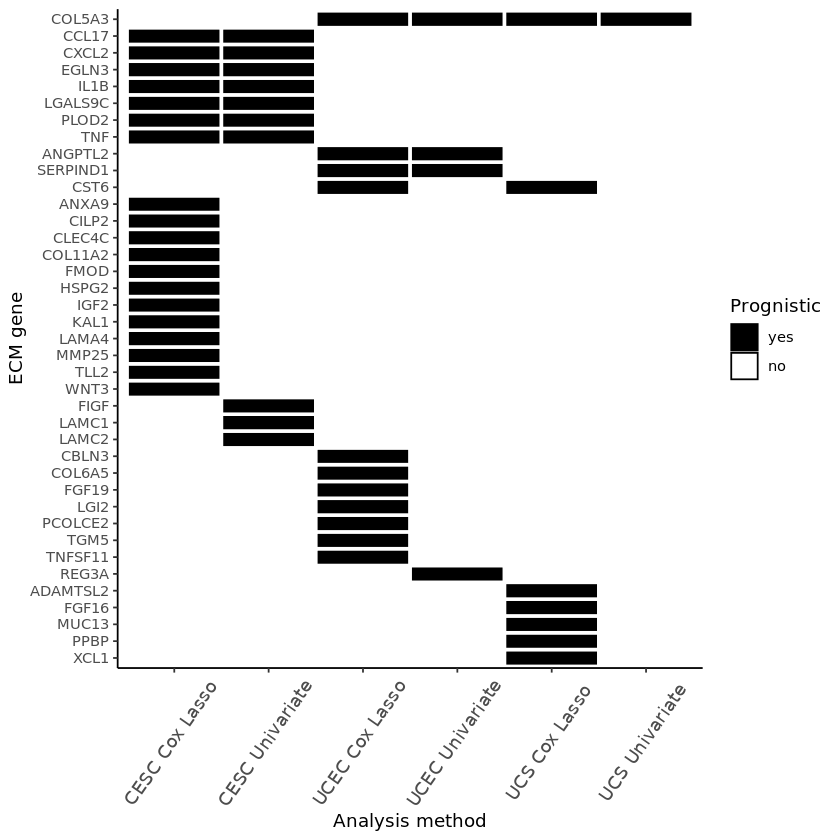

In [23]:
ggplot(hm_surv_df) +
    geom_tile(aes(x = sig_list, y = geneID_f, fill = value), color = "white", size = 1) +
    scale_fill_manual(values = c("yes" = "black", "no" = "white")) +
    theme_classic() +
    labs(x = "Analysis method", y = "ECM gene", fill = "Prognistic") +
    scale_x_discrete(
        labels = analysis_labs
    ) +
    theme(
        text = element_text(size = text_size, family = family),
        axis.text.x = element_text(size = text_size, angle = 55, vjust = 0.55, hjust = 0.55)
    ) +
    guides(fill = guide_legend(override.aes = list(color = "black", size = 0.5)))

ggsave(paste0(dirs$figures_dir, "/survival/prognostic_genes.png"), last_plot(), width = wd, dpi = dpi)